### Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import shap
# from captum.attr import IntegratedGradients, ShapleyValueSampling
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import math
import itertools

from libs.models import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

# Import data

In [2]:
# read data
df = pd.read_csv('data/data.csv')

# Prepare data for training

In [3]:
# prepare expanding window splits
periods = {
    '21' : '2020-01-01', # 2021 is the test set
    # '22' : '2021-01-01', # 2022 is the test set
    # '23' : '2022-01-01', # 2023 is the test set
    # '24': '2023-01-01' # 2024 is the test set
}

# identify dummy vs. numeric columns
feature_cols = [col for col in df.columns if col not in ['timestamp', 'ticker', 'target']]
nace_cols = [c for c in feature_cols if c.startswith('NACE_')]
dummy_cols = ['divi','divo'] # sin removed
macro_cols = ['discount', 'tms', 'dp', 'ep', 'svar'] # 'bm_macro'

# nummeric cols = cols not in cat and macro cols
numeric_cols = [c for c in feature_cols if c not in dummy_cols and c not in nace_cols and c not in macro_cols]

# feature_cols = numeric_cols + dummy_cols + nace_cols # reorder columns to have numeric first

df_raw = df.copy(deep=True)
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

# drop data from 2025
df_raw = df_raw[df_raw['timestamp'] < '2025-01-01']

In [4]:
C = df[numeric_cols].values         # shape = (n_rows, P_c)
X = df[macro_cols].values           # shape = (n_rows, P_x)

# 1) compute all pairwise products with broadcasting:
#    this gives shape (n_rows, P_c, P_x)
K = C[:,:,None] * X[:,None,:]

# 2) reshape to (n_rows, P_c * P_x)
Z = K.reshape(len(df), -1)

# 3) build the column names in the same order
xc_names = [
    f"{c}_x_{m}"
    for c in numeric_cols
    for m in macro_cols
]

# 4) wrap back into a DataFrame
df_xc = pd.DataFrame(Z, columns=xc_names, index=df.index)

feature_cols = numeric_cols + xc_names + dummy_cols + nace_cols
numeric_cols = numeric_cols + xc_names
cat_cols = dummy_cols + nace_cols
df_z = df_raw.merge(df_xc, left_index=True, right_index=True)
# drop macro_cols
df_z = df_z.drop(columns=macro_cols)
# sort columns by feature_cols
df_norm = df_z[['timestamp', 'ticker', 'target'] + feature_cols]

y_values = df_norm['target'].values.astype('float32')


In [5]:
# prepare containers
X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}
preprocessors = {}

for y, period in periods.items():
    period = pd.to_datetime(period)

    # split masks
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract raw feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols].copy()
    X_va_df = df_norm.loc[va_mask, feature_cols].copy()
    X_te_df = df_norm.loc[te_mask, feature_cols].copy()
    y_tr    = y_values[tr_mask]
    y_va    = y_values[va_mask]
    y_te    = y_values[te_mask]

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, val, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_va_df[numeric_cols] = X_va_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)


    # now fit scaler on numeric only
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough',  cat_cols)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors[y] = preprocessor

    # transform all splits
    X_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    X_val[y]   = preprocessor.transform(X_va_df).astype('float32')
    X_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # store targets as before
    y_train[y] = y_tr.reshape(-1, 1)
    y_val[y]   = y_va.reshape(-1, 1)
    y_test[y]  = y_te.reshape(-1, 1)


In [6]:
# moving to metal or CUDA GPU if available
device = torch.device(("cuda" if torch.cuda.is_available() 
                       else "mps" if torch.backends.mps.is_available() 
                       else "cpu"))
print("Using device:", device)

# general hyperparameters
hidden_depth = 3 # only hidden, excluding in- and output layers
hidden_width = [32,16,8] # int for all being equal width; list for different widths
learning_rate = 1e-4 # increased from 1e-4 as we have full batching
activation_fun = nn.ReLU # # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU nn.Identity

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 1e-3 # 1e-3 # currently 0 
lambda_l2 = 1e-3 # l2 regularization
dropout = 0.2

# general parmeters
patience = 10
print_freq = 100
epochs = 250
batch_size = 4096 # 8192 # 16384 # 2^1X adjust to your memory


Using device: mps


# Test hyperparameters

In [7]:
# training model with most data on multiple parameters
l1_space = [0.0, 1e-3] # [0.0]
l2_space = [0.0, 1e-3] # [1e-4, 1e-3, 5e-3, 1e-2] # np.geomspace(1e-4, 1e-2, num=4)
dropout_space = [0.2] # [0.0, 0.1, 0.2, 0.3] # np.geomspace(0.0, 0.3, num=4)
learning_rate_space = [learning_rate] # np.geomspace(1e-4, 5e-3, num=4)
depth_space = [1, 2, 3, 4, 5, 6, 7] # [1, 2, 3]
width_space = [8, 16, 32, 64, 128] # [32, 64, 128]

In [8]:
# current runtime: 4h 35m
best_models_size = {}
history_size = {}
models_21 = {}
year = '21'

for lambda_l1 in l1_space:
    for lambda_l2 in l2_space:
        for dropout in dropout_space:
            for learning_rate in learning_rate_space:
                for hidden_depth in depth_space:
                    for hidden_width in width_space:
                        np.random.seed(2024)
                        torch.manual_seed(2024)
                        print(f"""Training model for year '{year}...: 
                                lambda_l1       ={lambda_l1:.0e}
                                lambda_l2       ={lambda_l2:.0e}
                                dropout         ={dropout:.0e}
                                learning_rate   ={learning_rate:.0e}
                                hidden_depth    ={hidden_depth}
                                hidden_width    ={hidden_width}""")
                        # Initialize the model
                        input_dim = X_train[year].shape[1]
                        name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                        models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                        optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
                        train = MLPdataset(X_train[year], y_train[year])
                        val = MLPdataset(X_val[year], y_val[year])
                        best_models_size[name], history_size[name] = train_mlp(train,          
                                                        val,
                                                        models_21[name],
                                                        criterion,
                                                        epochs,
                                                        patience,
                                                        print_freq,
                                                        device,
                                                        optimizer,
                                                        lambda_l1=lambda_l1,
                                                        lambda_l2=lambda_l2,
                                                        batch_size=batch_size,
                                                        shuffle_train=True,
                                                        shuffle_val=False,
                                                        save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth'
                                                        )

Training model for year '21...: 
                                lambda_l1       =0e+00
                                lambda_l2       =0e+00
                                dropout         =2e-01
                                learning_rate   =1e-04
                                hidden_depth    =1
                                hidden_width    =8
Epoch 100/250  - Train Loss: 2.56126E-02  - Val Loss: 2.02286E-02
Early stopping at epoch 178
Best val loss: 1.99473E-02
Model saved to models/hyperparam_test/mlp_y21_l10.0_l20.0_drop0.2_lr0.0001_w8_d1.pth
Training model for year '21...: 
                                lambda_l1       =0e+00
                                lambda_l2       =0e+00
                                dropout         =2e-01
                                learning_rate   =1e-04
                                hidden_depth    =1
                                hidden_width    =16
Epoch 100/250  - Train Loss: 2.57615E-02  - Val Loss: 2.06108E-02
Early stopping at

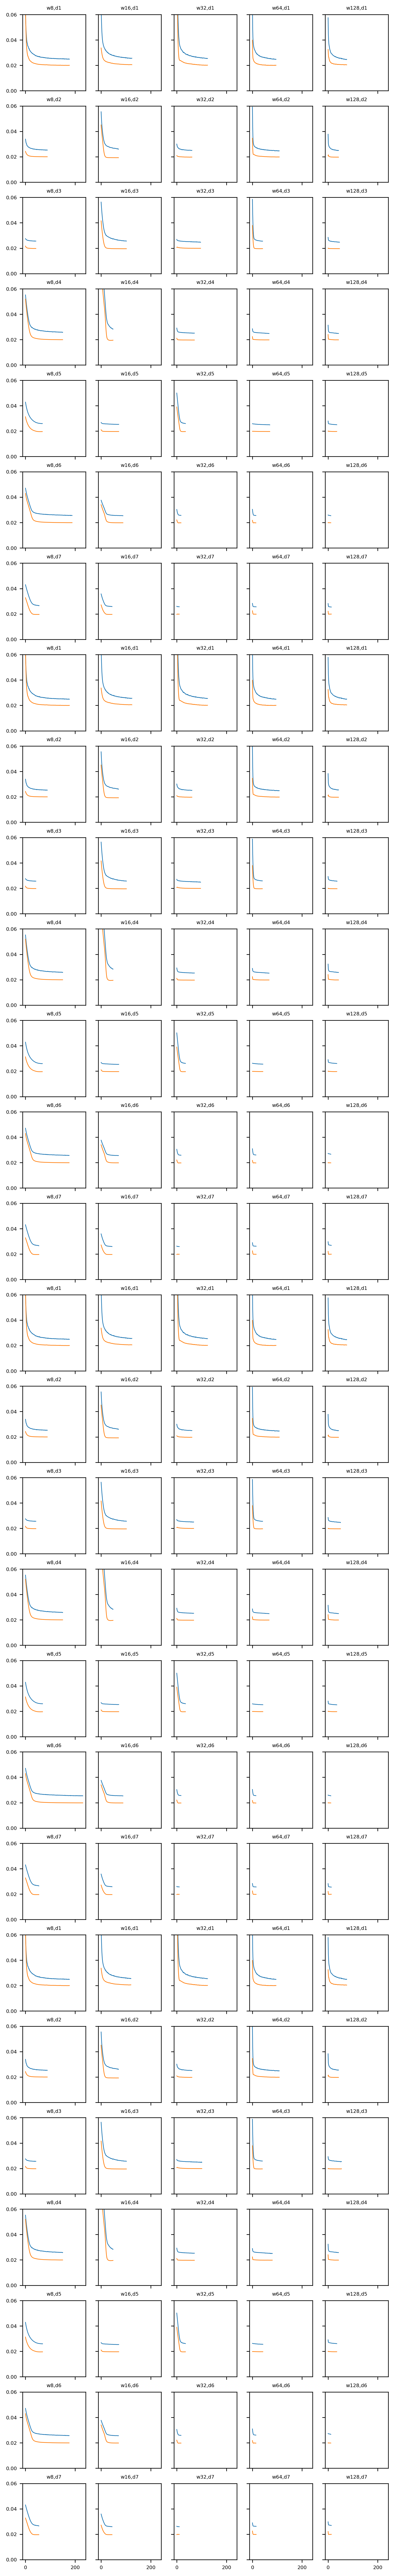

In [9]:
# build the full list of parameter tuples
param_grid = list(itertools.product(
    l2_space,
    dropout_space,
    l1_space,
    learning_rate_space,
    depth_space,
    width_space
))

n_plots = len(param_grid)                     # = 192
ncols   = 5                                   # eight columns
nrows   = math.ceil(n_plots / ncols)          # 24 rows

# each “tile” will be very short – adjust `row_height` if you want more vertical space
row_height = 2                             # inches per row
fig = plt.figure(figsize=(8, row_height * nrows))
axes = fig.subplots(nrows, ncols, sharex=True, sharey=True).flatten()

for ax, params in zip(axes, param_grid):
    lambda_l2, dropout, lambda_l1, lr, hidden_depth, hidden_width = params
    name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{lr}_w{hidden_width}_d{hidden_depth}'
    hist = history_size[name]     # assuming this dict exists
    ax.plot(hist['train_loss'],  linewidth=0.8)
    ax.plot(hist['val_loss'],    linewidth=0.8)
    ax.set_title(f"w{hidden_width},d{hidden_depth}", fontsize=6)
    ax.label_outer()            # only show outer tick labels

for ax in axes[len(param_grid):]:
    ax.set_visible(False)

# adjust the font size of the x/y ticks
for ax in axes:
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(6)


for ax in axes:
    ax.set_ylim(0, 0.06)
# add a single legend and suptitle
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=8)
# fig.suptitle("All Training/Validation Losses (8-column layout)", y=1.02, fontsize=10)

# plt.tight_layout()
plt.show()


In [10]:
device = torch.device('cpu')
criterion = nn.MSELoss()
val = MLPdataset(X_val[year], y_val[year])

for hidden_depth in depth_space:
    for hidden_width in width_space:
        for dropout in dropout_space:
            for lambda_l2 in l2_space:
                for lambda_l1 in l1_space:
                    for learning_rate in learning_rate_space:
                        name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                        load_path = (
                            f"models/hyperparam_test/mlp_y{year}" # error in prev code
                            f"_l1{lambda_l1}"
                            f"_l2{lambda_l2}"
                            f"_drop{dropout}"
                            f"_lr{learning_rate}"
                            f"_w{hidden_width}"
                            f"_d{hidden_depth}.pth"
                        )
                        model = MLPModel(
                            input_dim  = X_train[year].shape[1],
                            depth      = hidden_depth,
                            width      = hidden_width,
                            dropout    = dropout,
                            activation = activation_fun,
                        ).to(device)
                        model.load_state_dict(torch.load(load_path, map_location=device))
                        model.eval()
                        best_models_size[name] = model

val_loader  = DataLoader(val, batch_size=batch_size, shuffle=False)

In [11]:
# # assume best_models_size has been filled as in your snippet,

# loss_matrix   = np.zeros((len(depth_space), len(width_space)))
# val_loss_21   = {}  # overwrite or reuse your existing dict

# for i, hidden_depth in enumerate(depth_space):
#     for j, hidden_width in enumerate(width_space):
#         # build the exact same key you used when loading
#         name = f'l1{l1_space[0]}_l2{l2_space[0]}' \
#                f'_drop{dropout_space[0]}_lr{learning_rate_space[0]}' \
#                f'_w{hidden_width}_d{hidden_depth}'
#         model = best_models_size[name]
#         model.eval()
        
#         # compute mean validation loss for this (depth, width)
#         losses = []
#         with torch.no_grad():
#             for X_batch, y_batch in val_loader:
#                 X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#                 y_pred = model(X_batch)
#                 losses.append(criterion(y_pred, y_batch).item())
#         mean_loss = np.mean(losses)
        
#         val_loss_21[name] = mean_loss
#         loss_matrix[i, j] = mean_loss

# # now plot the heatmap
# fig, ax = plt.subplots()
# im = ax.imshow(loss_matrix, aspect='auto')
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('Validation Loss')

# # label ticks with your hyper-param values
# ax.set_xticks(np.arange(len(width_space)))
# ax.set_xticklabels(width_space)
# ax.set_xlabel('Hidden Width')

# ax.set_yticks(np.arange(len(depth_space)))
# ax.set_yticklabels(depth_space)
# ax.set_ylabel('Hidden Depth')

# ax.set_title('Validation Loss by Network Depth & Width')
# plt.tight_layout()
# plt.show()

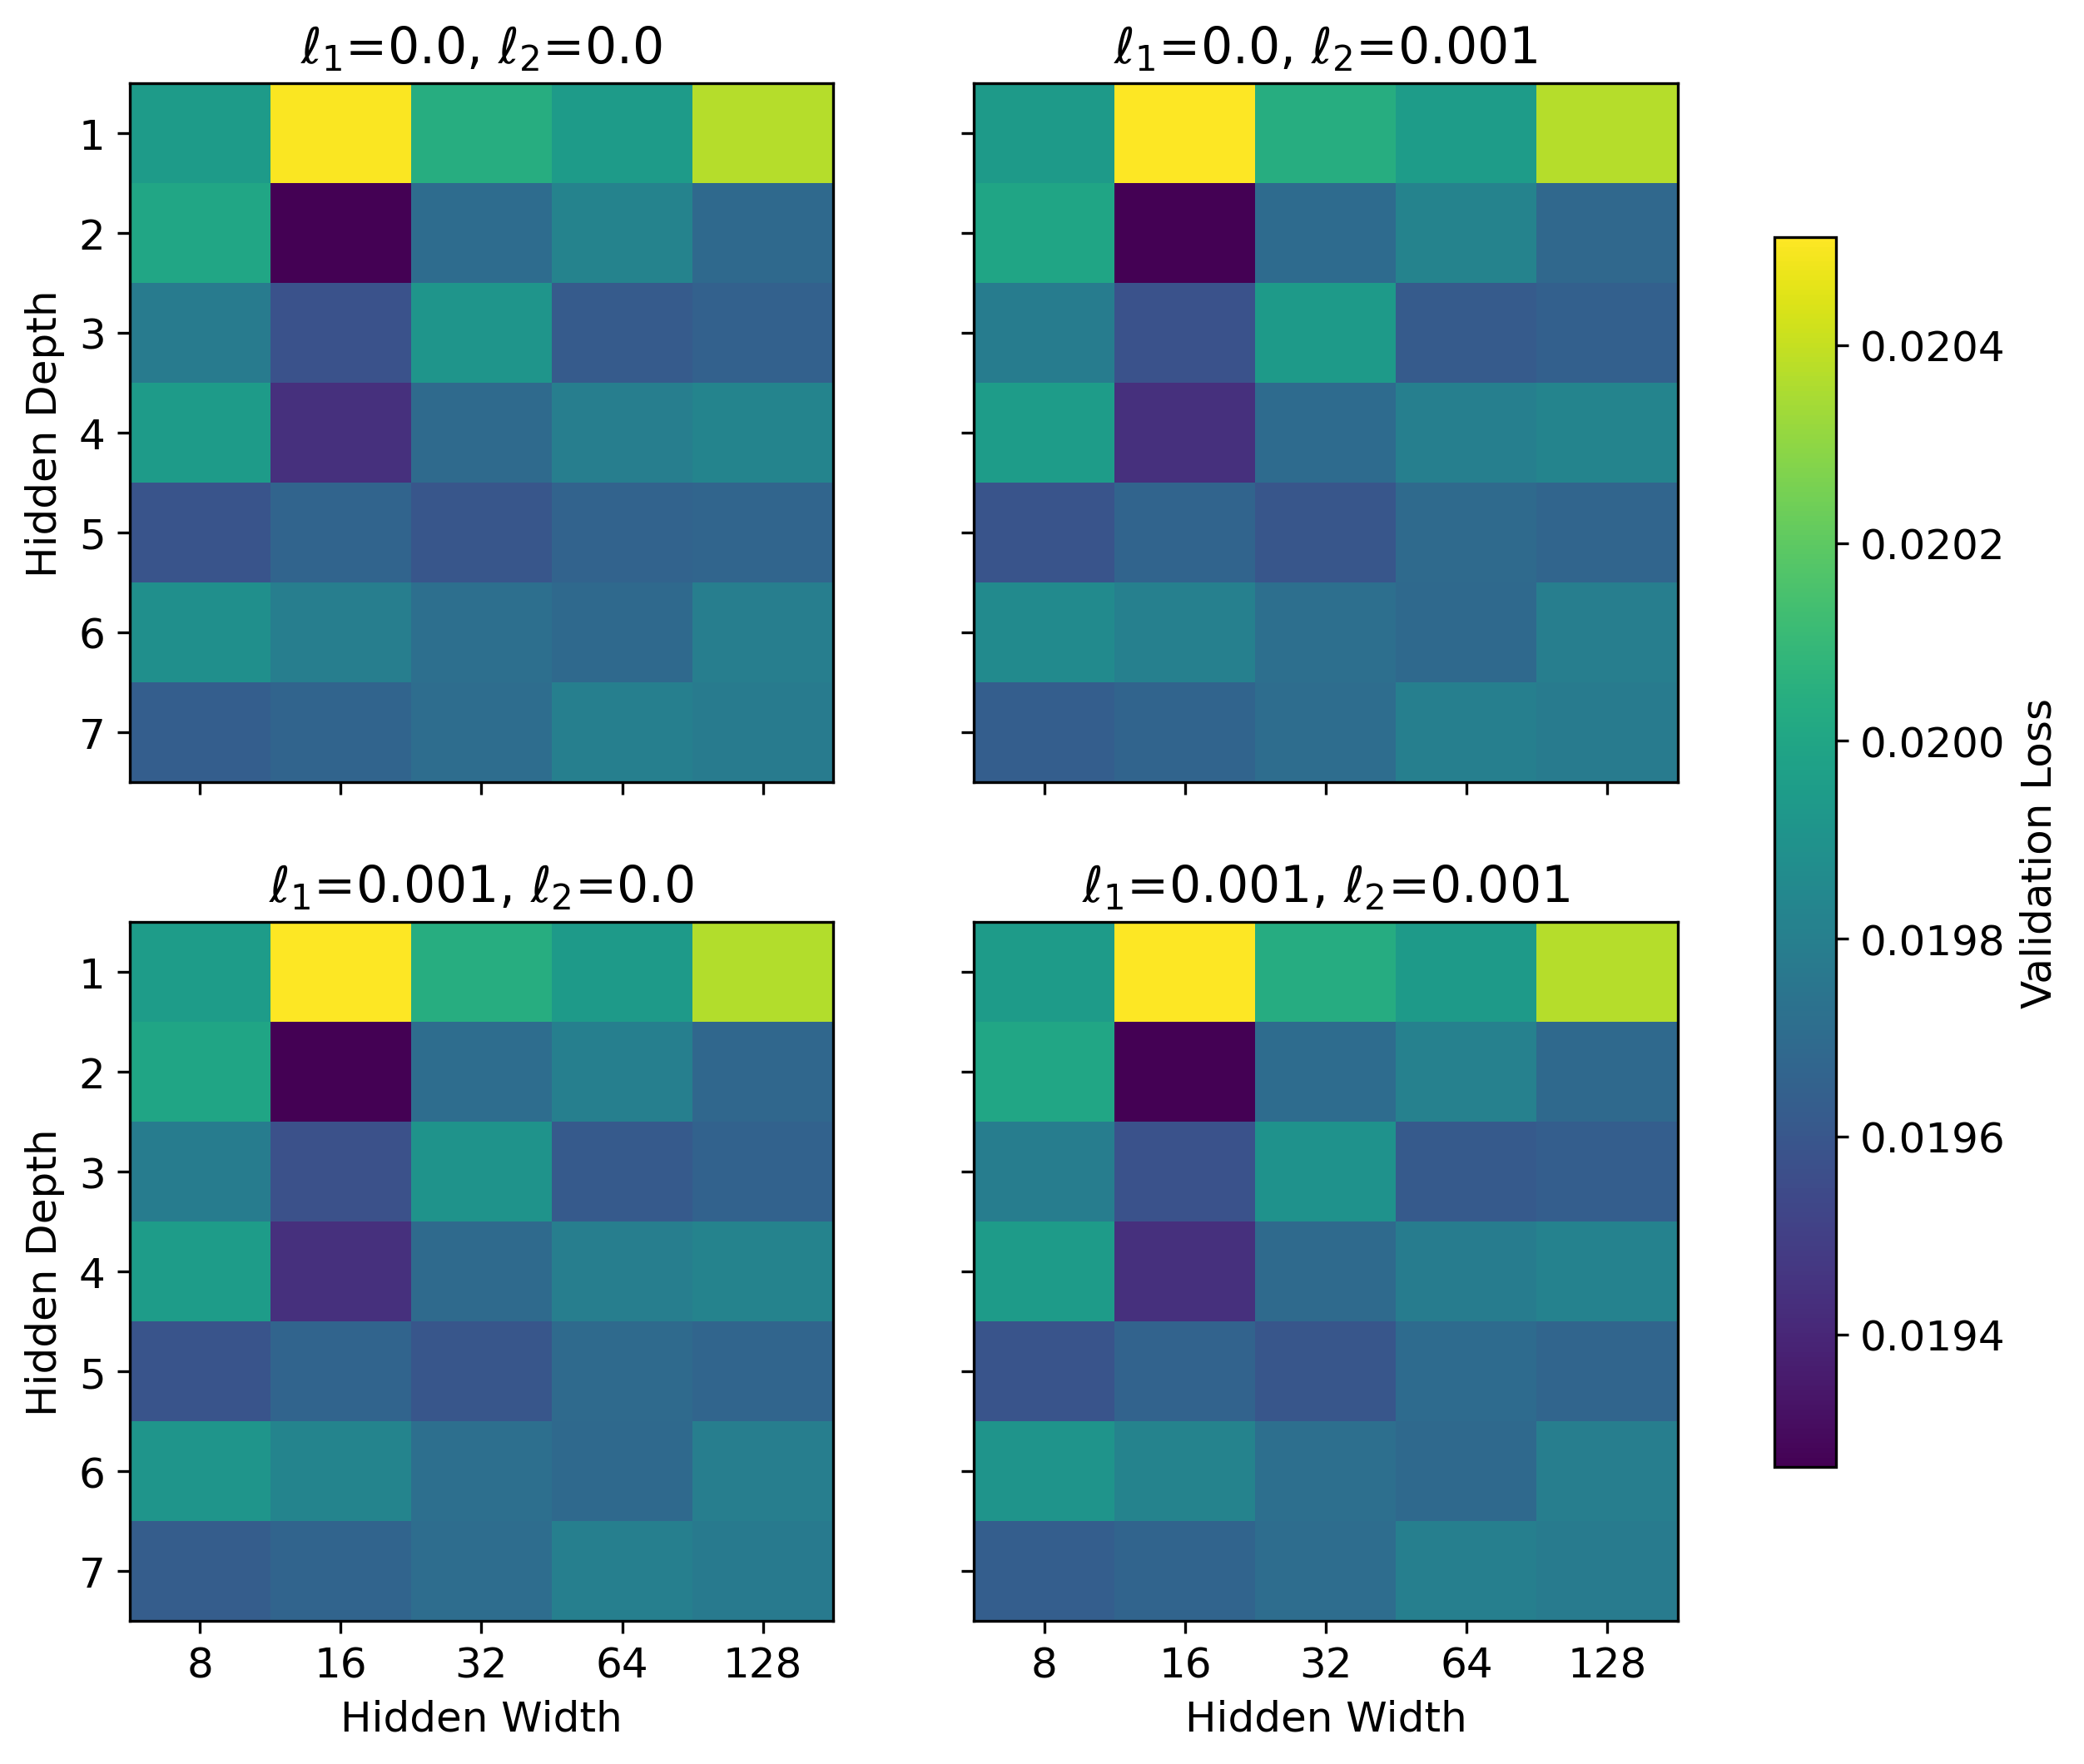

In [12]:
n_l1 = len(l1_space)
n_l2 = len(l2_space)

# first pass: build and collect all the loss‐matrices so we can compute a global vmin/vmax
all_losses = []
loss_matrices = [[None]*n_l2 for _ in range(n_l1)]
for i, lambda_l1 in enumerate(l1_space):
    for j, lambda_l2 in enumerate(l2_space):
        mat = np.zeros((len(depth_space), len(width_space)))
        for di, hidden_depth in enumerate(depth_space):
            for wj, hidden_width in enumerate(width_space):
                name = (
                    f"l1{lambda_l1}_l2{lambda_l2}"
                    f"_drop{dropout_space[0]}_lr{learning_rate_space[0]}"
                    f"_w{hidden_width}_d{hidden_depth}"
                )
                model = best_models_size[name]
                model.eval()
                losses = []
                with torch.no_grad():
                    for Xb, yb in val_loader:
                        Xb, yb = Xb.to(device), yb.to(device)
                        yp     = model(Xb)
                        losses.append(criterion(yp, yb).item())
                mat[di, wj] = np.mean(losses)
        loss_matrices[i][j] = mat
        all_losses.append(mat)

# global min/max
vmin = np.min(all_losses)
vmax = np.max(all_losses)
# pick a center low in the range to "stretch" the bottom end
vcenter = vmin + 0.5*(vmax - vmin)

norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'viridis'

fig, axes = plt.subplots(n_l1, n_l2, figsize=(5 * n_l2, 4 * n_l1), squeeze=False)

for i in range(n_l1):
    for j in range(n_l2):
        ax = axes[i, j]
        mat = loss_matrices[i][j]
        im = ax.imshow(mat, aspect='auto', cmap=cmap, norm=norm)

        # ticks & labels
        ax.set_xticks(np.arange(len(width_space)))
        ax.set_xticklabels(width_space)
        ax.set_yticks(np.arange(len(depth_space)))
        ax.set_yticklabels(depth_space)

        # only bottom row: show x-axis label
        if i == n_l1 - 1:
            ax.set_xlabel('Hidden Width')
        else:
            ax.tick_params(labelbottom=False)

        # only left column: show y-axis label
        if j == 0:
            ax.set_ylabel('Hidden Depth')
        else:
            ax.tick_params(labelleft=False)

        # title for each panel
        lambda_l1 = l1_space[i]
        lambda_l2 = l2_space[j]
        ax.set_title(f"$\\ell_1$={lambda_l1}, $\\ell_2$={lambda_l2}")

# shared colorbar
cbar = fig.colorbar(im, ax=axes.flatten().tolist(), shrink=0.8)
cbar.set_label('Validation Loss')

# save the figure
fig.savefig('figs/valloss_heat_size.png', dpi=300)

# plt.tight_layout()
plt.show()

In [16]:
# training model with most data on multiple parameters
l1_space = [0.0, 1e-3] # [0.0]
l2_space = [0.0, 1e-3] # [1e-4, 1e-3, 5e-3, 1e-2] # np.geomspace(1e-4, 1e-2, num=4)
dropout_space = [dropout] # [0.0, 0.1, 0.2, 0.3] # np.geomspace(0.0, 0.3, num=4)
learning_rate_space = [learning_rate] # np.geomspace(1e-4, 5e-3, num=4)
# depth_space = [1, 2, 3, 4, 5, 6, 7, 8] # [1, 2, 3]
width_space = [[32], [32, 16], [32, 16, 8], [32, 16, 8, 4], [32,16,8,4,2]] # [32, 64, 128]

In [ ]:
best_models_pyramid = {}
history_pyramid = {}
for lambda_l1 in l1_space:
    for lambda_l2 in l2_space:
        for dropout in dropout_space:
            for learning_rate in learning_rate_space:
                for hidden_width in width_space:
                    hidden_depth = len(hidden_width)
                    np.random.seed(42)
                    torch.manual_seed(42)
                    print(f"""Training model for year '{year}...: 
                            lambda_l1       ={lambda_l1:.0e}
                            lambda_l2       ={lambda_l2:.0e}
                            dropout         ={dropout:.0e}
                            learning_rate   ={learning_rate:.0e}
                            hidden_depth    ={hidden_depth}
                            hidden_width    ={hidden_width}""")
                    # Initialize the model
                    input_dim = X_train[year].shape[1]
                    name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                    models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                    optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
                    train = MLPdataset(X_train[year], y_train[year])
                    val = MLPdataset(X_val[year], y_val[year])
                    best_models_pyramid[name], history_pyramid[name] = train_mlp(train,          
                                                    val,
                                                    models_21[name],
                                                    criterion,
                                                    epochs,
                                                    patience,
                                                    print_freq,
                                                    device,
                                                    optimizer,
                                                    lambda_l1=lambda_l1,
                                                    lambda_l2=lambda_l2,
                                                    batch_size=batch_size,
                                                    shuffle_train=True,
                                                    shuffle_val=False,
                                                    save_path=f'models/hyperparam_test/mlp_y23_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth'
                                                    )

Training model for year '21...: 
                            lambda_l1       =0e+00
                            lambda_l2       =0e+00
                            dropout         =2e-01
                            learning_rate   =1e-04
                            hidden_depth    =1
                            hidden_width    =[32]
Early stopping at epoch 78
Best val loss: 1.98958E-02
Model saved to models/hyperparam_test/mlp_y23_l10.0_l20.0_drop0.2_lr0.0001_w[32]_d1.pth
Training model for year '21...: 
                            lambda_l1       =0e+00
                            lambda_l2       =0e+00
                            dropout         =2e-01
                            learning_rate   =1e-04
                            hidden_depth    =2
                            hidden_width    =[32, 16]
Early stopping at epoch 34
Best val loss: 1.96843E-02
Model saved to models/hyperparam_test/mlp_y23_l10.0_l20.0_drop0.2_lr0.0001_w[32, 16]_d2.pth
Training model for year '21...: 
       

In [ ]:
device = torch.device('cpu')
criterion = nn.MSELoss()
val = MLPdataset(X_val[year], y_val[year])


for hidden_width in width_space:
    hidden_depth = len(hidden_width)
    for dropout in dropout_space:
        for lambda_l2 in l2_space:
            for lambda_l1 in l1_space:
                for learning_rate in learning_rate_space:
                    name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                    load_path = (
                        f"models/hyperparam_test/mlp_y{year}" # error in prev code
                        f"_l1{lambda_l1}"
                        f"_l2{lambda_l2}"
                        f"_drop{dropout}"
                        f"_lr{learning_rate}"
                        f"_w{hidden_width}"
                        f"_d{hidden_depth}.pth"
                    )
                    model = MLPModel(
                        input_dim  = X_train[year].shape[1],
                        depth      = hidden_depth,
                        width      = hidden_width,
                        dropout    = dropout,
                        activation = activation_fun,
                    ).to(device)
                    model.load_state_dict(torch.load(load_path, map_location=device))
                    model.eval()
                    best_models_size[name] = model

val_loader  = DataLoader(val, batch_size=batch_size, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: 'models/hyperparam_test/mlp_y21_l10.0_l20.0_drop0.2_lr0.0001_w[32]_d1.pth'

In [ ]:
n_l1 = len(l1_space)
n_l2 = len(l2_space)

# first pass: build and collect all the loss‐matrices so we can compute a global vmin/vmax
all_losses = []
loss_matrices = [[None]*n_l2 for _ in range(n_l1)]
for i, lambda_l1 in enumerate(l1_space):
    for j, lambda_l2 in enumerate(l2_space):
        mat = np.zeros((len(depth_space), len(width_space)))
        for di, hidden_depth in enumerate(depth_space):
            for wj, hidden_width in enumerate(width_space):
                name = (
                    f"l1{lambda_l1}_l2{lambda_l2}"
                    f"_drop{dropout_space[0]}_lr{learning_rate_space[0]}"
                    f"_w{hidden_width}_d{hidden_depth}"
                )
                model = best_models_size[name]
                model.eval()
                losses = []
                with torch.no_grad():
                    for Xb, yb in val_loader:
                        Xb, yb = Xb.to(device), yb.to(device)
                        yp     = model(Xb)
                        losses.append(criterion(yp, yb).item())
                mat[di, wj] = np.mean(losses)
        loss_matrices[i][j] = mat
        all_losses.append(mat)

# global min/max
vmin = np.min(all_losses)
vmax = np.max(all_losses)
# pick a center low in the range to "stretch" the bottom end
vcenter = vmin + 0.5*(vmax - vmin)

norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap = 'viridis'

fig, axes = plt.subplots(n_l1, n_l2, figsize=(5 * n_l2, 4 * n_l1), squeeze=False)

for i in range(n_l1):
    for j in range(n_l2):
        ax = axes[i, j]
        mat = loss_matrices[i][j]
        im = ax.imshow(mat, aspect='auto', cmap=cmap, norm=norm)

        # ticks & labels
        ax.set_xticks(np.arange(len(width_space)))
        ax.set_xticklabels(width_space)
        ax.set_yticks(np.arange(len(depth_space)))
        ax.set_yticklabels(depth_space)

        # only bottom row: show x-axis label
        if i == n_l1 - 1:
            ax.set_xlabel('Hidden Width')
        else:
            ax.tick_params(labelbottom=False)

        # only left column: show y-axis label
        if j == 0:
            ax.set_ylabel('Hidden Depth')
        else:
            ax.tick_params(labelleft=False)

        # title for each panel
        lambda_l1 = l1_space[i]
        lambda_l2 = l2_space[j]
        ax.set_title(f"$\\ell_1$={lambda_l1}, $\\ell_2$={lambda_l2}")

# shared colorbar
cbar = fig.colorbar(im, ax=axes.flatten().tolist(), shrink=0.8)
cbar.set_label('Validation Loss')

# save the figure
fig.savefig('figs/valloss_heat_size.png', dpi=300)

# plt.tight_layout()
plt.show()

In [ ]:
# training model with most data on multiple parameters
l1_space = [0.0, 1e-4, 1e-3, 1e-2] # [0.0]
l2_space = [0.0, 1e-4, 1e-3, 1e-2] # [1e-4, 1e-3, 5e-3, 1e-2] # np.geomspace(1e-4, 1e-2, num=4)
dropout_space = [0.0, 0.1, 0.2, 0.3] # np.geomspace(0.0, 0.3, num=4)
learning_rate_space = [learning_rate] # np.geomspace(1e-4, 5e-3, num=4)
depth_space = [5] # [1, 2, 3]
width_space = [32] # [32, 64, 128]

In [ ]:
best_models_reg = {}
history_reg = {}
for lambda_l1 in l1_space:
    for lambda_l2 in l2_space:
        for dropout in dropout_space:
            for learning_rate in learning_rate_space:
                for hidden_depth in depth_space:
                    for hidden_width in width_space:
                        np.random.seed(42)
                        torch.manual_seed(42)
                        print(f"""Training model for year '{year}...: 
                                lambda_l1       ={lambda_l1:.0e}
                                lambda_l2       ={lambda_l2:.0e}
                                dropout         ={dropout:.0e}
                                learning_rate   ={learning_rate:.0e}
                                hidden_depth    ={hidden_depth}
                                hidden_width    ={hidden_width}""")
                        # Initialize the model
                        input_dim = X_train[year].shape[1]
                        name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                        models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
                        optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
                        train = MLPdataset(X_train[year], y_train[year])
                        val = MLPdataset(X_val[year], y_val[year])
                        best_models_reg[name], history_reg[name] = train_mlp(train,          
                                                        val,
                                                        models_21[name],
                                                        criterion,
                                                        epochs,
                                                        patience,
                                                        print_freq,
                                                        device,
                                                        optimizer,
                                                        lambda_l1=lambda_l1,
                                                        lambda_l2=lambda_l2,
                                                        batch_size=batch_size,
                                                        shuffle_train=True,
                                                        shuffle_val=False,
                                                        save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}.pth'
                                                        )

Training model for year '21...: 
                                lambda_l1       =0e+00
                                lambda_l2       =0e+00
                                dropout         =0e+00
                                learning_rate   =1e-04
                                hidden_depth    =5
                                hidden_width    =32
Early stopping at epoch 94
Best val loss: 1.96344E-02
Model saved to models/mlp_y21_l10.0_l20.0_drop0.0_lr0.0001_w32_d5.pth
Training model for year '21...: 
                                lambda_l1       =1e-04
                                lambda_l2       =0e+00
                                dropout         =0e+00
                                learning_rate   =1e-04
                                hidden_depth    =5
                                hidden_width    =32
Epoch 100/150  - Train Loss: 2.24178E-02  - Val Loss: 1.97729E-02
Early stopping at epoch 102
Best val loss: 1.96274E-02
Model saved to models/mlp_y21_l10.0001_l20.

In [ ]:
device = torch.device('cpu')
criterion = nn.MSELoss()
val = MLPdataset(X_val[year], y_val[year])

# load models

for hidden_depth in depth_space:
    for hidden_width in width_space:
        for dropout in dropout_space:
            for lambda_l2 in l2_space:
                for lambda_l1 in l1_space:
                    for learning_rate in learning_rate_space:
                        name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}'
                        load_path = (
                            f"models/hyperparam_test/mlp_y{year}"
                            f"_l1{lambda_l1}"
                            f"_l2{lambda_l2}"
                            f"_drop{dropout}"
                            f"_lr{learning_rate}"
                            f"_w{hidden_width}"
                            f"_d{hidden_depth}.pth"
                        )
                        model = MLPModel(
                            input_dim  = X_train[year].shape[1],
                            depth      = hidden_depth,
                            width      = hidden_width,
                            dropout    = dropout,
                            activation = activation_fun,
                        ).to(device)
                        model.load_state_dict(torch.load(load_path, map_location=device))
                        model.eval()
                        best_models_reg[name] = model

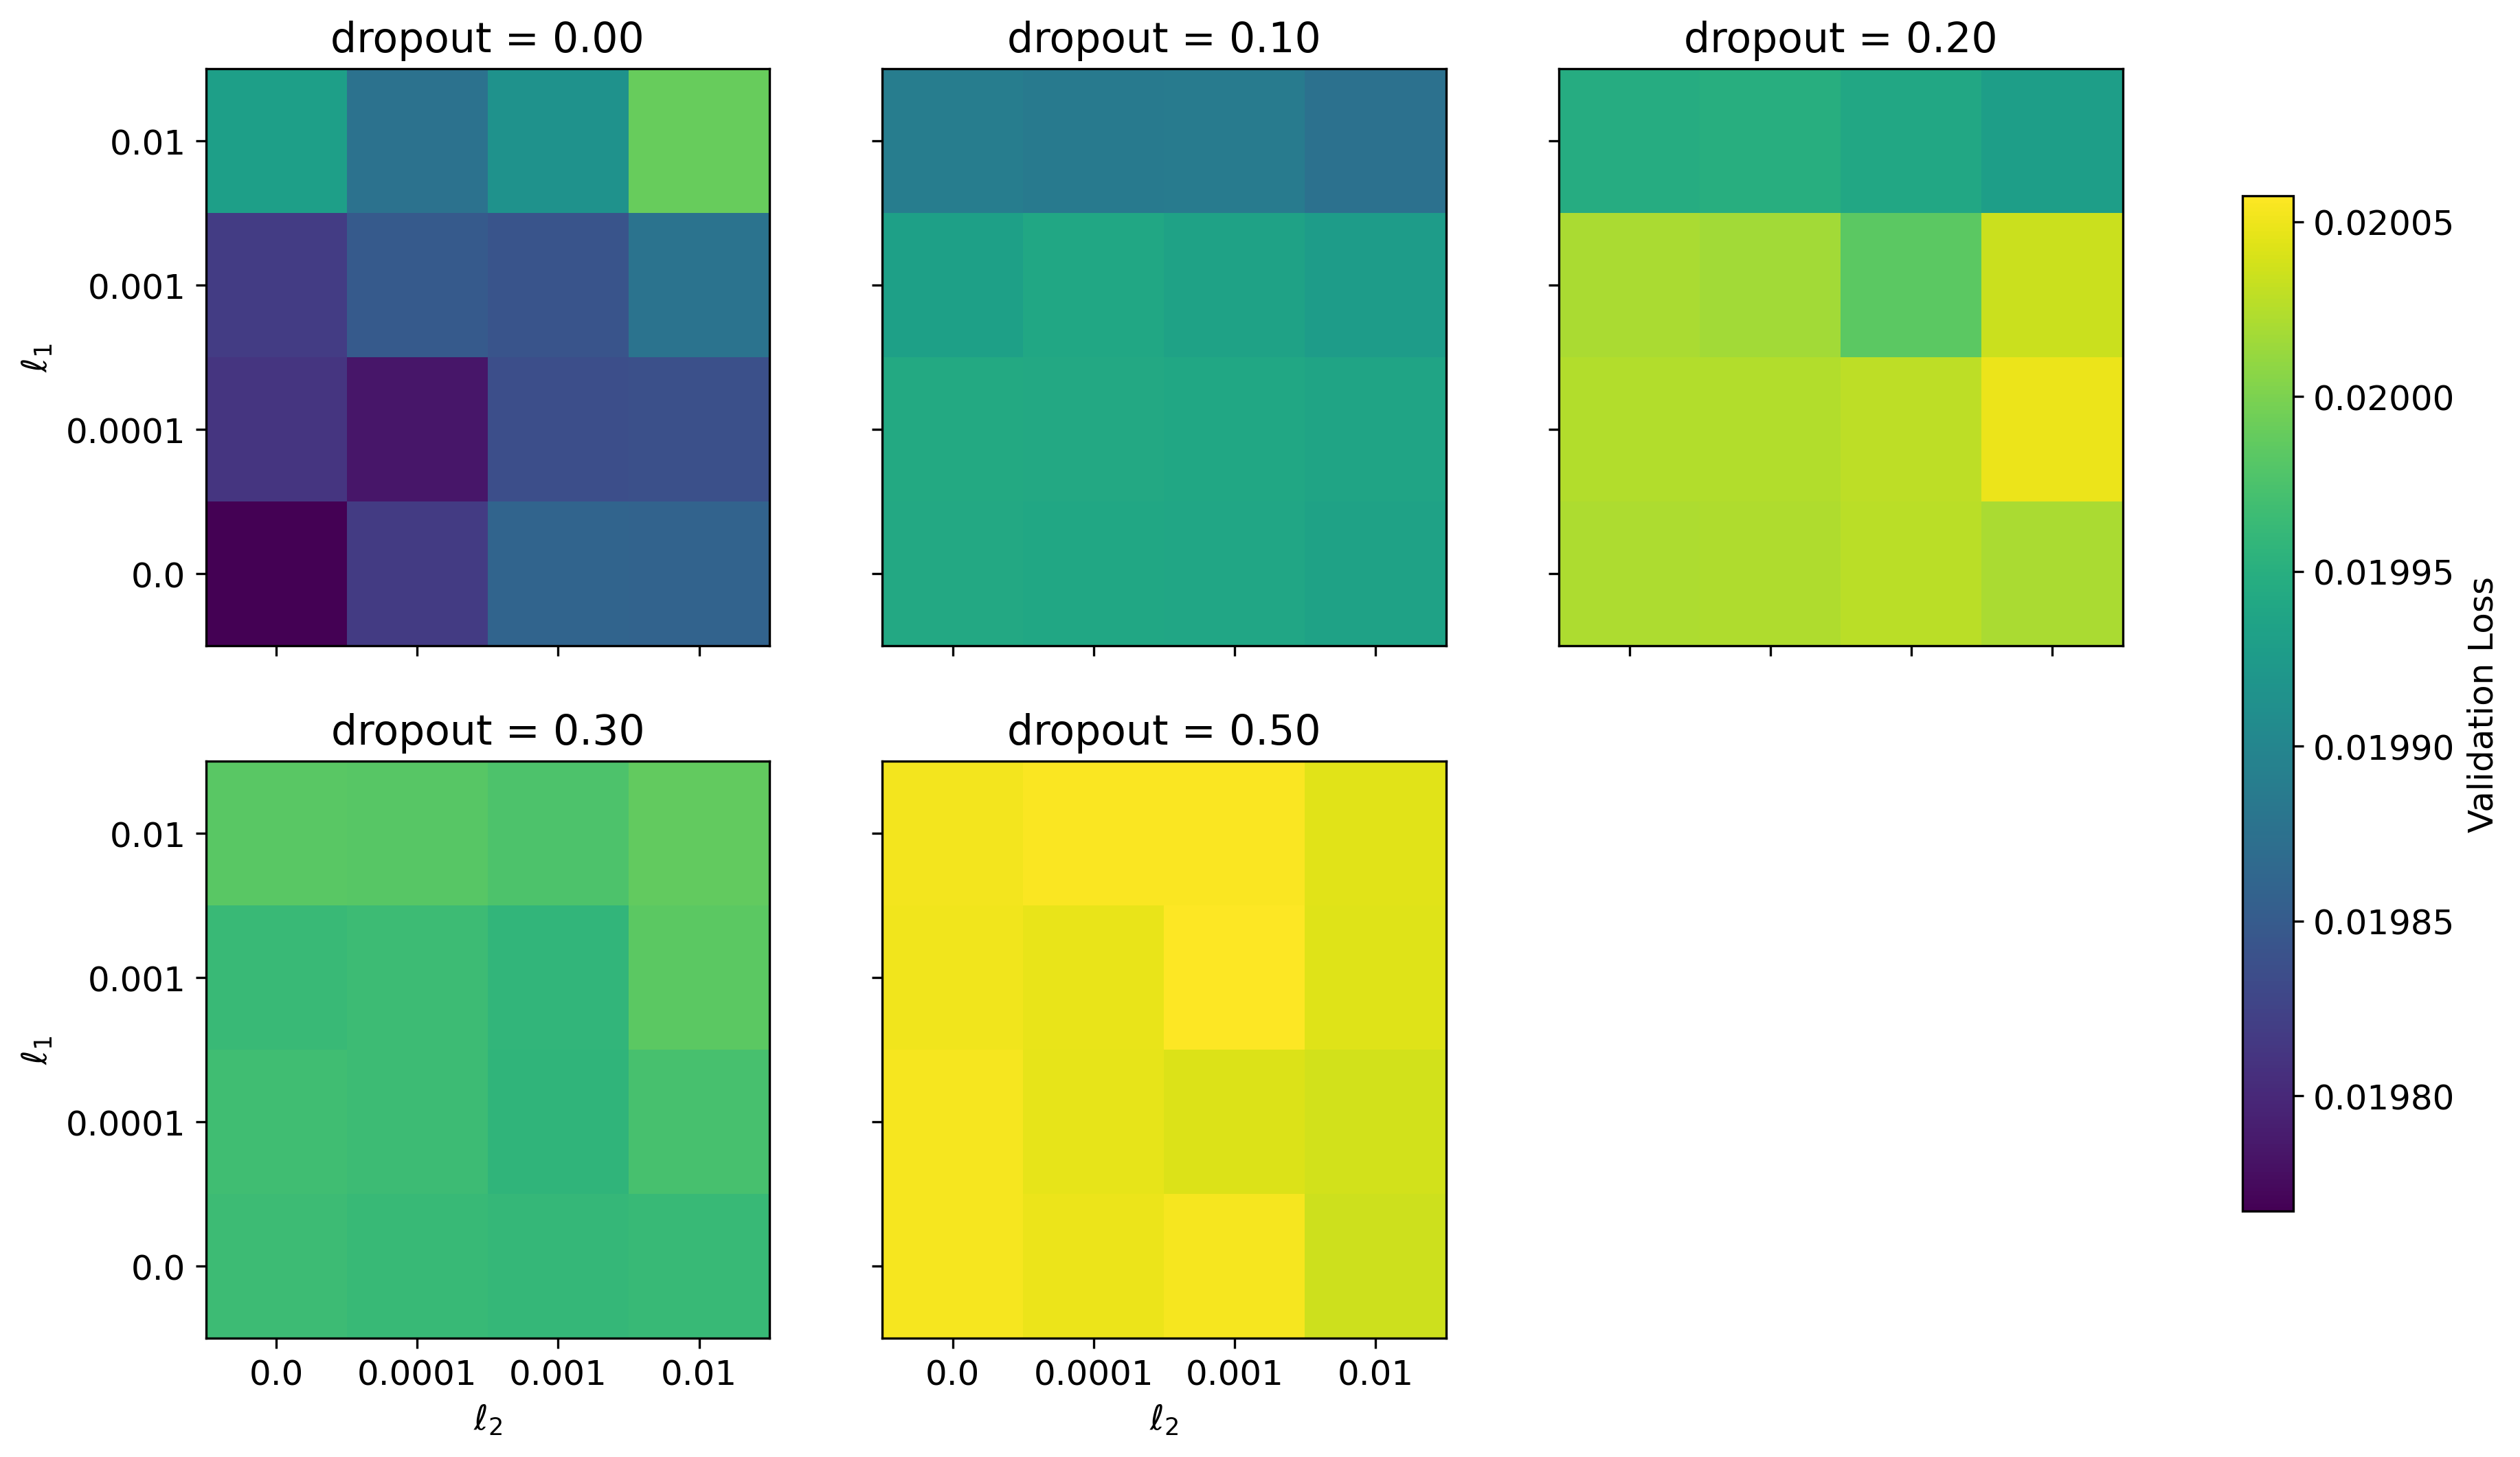

In [ ]:
n_l1   = len(l1_space)
n_l2   = len(l2_space)
n_drop = len(dropout_space)

# 1) Build (n_drop, n_l1, n_l2) mean‐loss array (same as before)
losses = np.zeros((n_drop, n_l1, n_l2))
for di, dropout in enumerate(dropout_space):
    for i, lambda_l1 in enumerate(l1_space):
        for j, lambda_l2 in enumerate(l2_space):
            tmp = []
            for hidden_depth in depth_space:
                for hidden_width in width_space:
                    name = (
                        f"l1{lambda_l1}_l2{lambda_l2}"
                        f"_drop{dropout}_lr{learning_rate_space[0]}"
                        f"_w{hidden_width}_d{hidden_depth}"
                    )
                    model = best_models_reg[name]
                    model.eval()
                    batch_losses = []
                    with torch.no_grad():
                        for Xb, yb in val_loader:
                            Xb, yb = Xb.to(device), yb.to(device)
                            yp     = model(Xb)
                            batch_losses.append(criterion(yp, yb).item())
                    tmp.append(np.mean(batch_losses))
            losses[di, i, j] = np.mean(tmp)

# 2) global color‐scale
vmin    = losses.min()
vmax    = losses.max()
vcenter = vmin + 0.5*(vmax - vmin)
norm    = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap    = 'viridis'

# 3) layout: at most 3 columns
ncols = min(3, n_drop)
nrows = math.ceil(n_drop / ncols)

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(5*ncols, 4*nrows),
                         squeeze=False)
axes_flat = axes.flatten()

for idx, dropout in enumerate(dropout_space):
    ax = axes_flat[idx]
    im = ax.imshow(
        losses[idx],
        aspect='auto',
        cmap=cmap,
        norm=norm,
        origin='lower'
    )

    # set yticks = ℓ₁, always
    ax.set_yticks(np.arange(n_l1))
    ax.set_yticklabels(l1_space)

    # set xticks = ℓ₂, but we'll hide them on the first row
    ax.set_xticks(np.arange(n_l2))
    ax.set_xticklabels(l2_space)

    # hide x‐labels & ticks for first‐row subplots
    if idx < ncols:
        ax.tick_params(labelbottom=False)
    else:
        ax.set_xlabel(r'$\ell_2$')

    # only first‐column subplots show y‐label
    if idx % ncols == 0:
        ax.set_ylabel(r'$\ell_1$')
    else:
        ax.tick_params(labelleft=False)

    ax.set_title(f"dropout = {dropout:.2f}")

# remove any unused axes
for ax in axes_flat[n_drop:]:
    fig.delaxes(ax)

# single shared colorbar
cbar = fig.colorbar(im, ax=axes_flat[:n_drop].tolist(), shrink=0.8)
cbar.set_label('Validation Loss')

# plt.tight_layout()
plt.show()
